*Example use of xarray/dask/xgcm with GIGATL1 extractions:*

## Various operations on surface CROCO files

- Plotting of SST
- Computation and plotting of relative vorticity

#########################

In [1]:
%load_ext memory_profiler

import xarray as xr
import numpy as np

#import xroms
from xgcm import Grid

#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Functions to adapt croco outputs to xgcm
##########################################

def adjust_coords(ds):

    if 'nav_lon_u' not in ds.coords:
        ##########################
        # for regular CROCO files:
        ds = ds.set_coords([c for c in ds.variables if 'lon' in c or 'lat' in c ])

    else:
        ##########################
        # for XIOS files:
        
        ds = ds.rename({'time_counter': 'time'})
        
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])

        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})

        # change axis names to xi,eta (instead of x,y)
        _dims = (d for d in ['x_u', 'x_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'xi' + d[1:]}) 

        _dims = (d for d in ['y_v', 'y_rho'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: 'eta' + d[1:]}) 


        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 

        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('nav_lat','lat').replace('nav_lon','lon')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='deg', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )

    ##########################
    # For all types  
    if 'eta_psi' in ds.dims: ds = ds.rename({'eta_psi': 'eta_v'}) 
    if 'xi_psi' in ds.dims: ds = ds.rename({'xi_psi': 'xi_u'}) 
        

    ##########################
    # Create xgcm grid
    coords={'xi':{'center':'xi_rho', 'inner':'xi_u'}, 
            'eta':{'center':'eta_rho', 'inner':'eta_v'}, 
            's':{'center':'s_rho', 'outer':'s_w'}}

    ds.attrs['xgcm-Grid'] = Grid(ds, coords=coords, periodic=[])


    return ds

    
def add_grd(ds,grd):
    
    ##########################
    for variable in grd.data_vars.keys():
        #print(variable)
        ds[variable] = grd[variable]
        
    ds['mask_rho'] = ds.mask_rho.where(ds.mask_rho>0,np.nan)
    
    if 'lon_psi' not in ds.coords: 
        #ds['lon_psi'] = grd['lon_psi']
        #ds['lat_psi'] = grd['lat_psi']
        ds = ds.assign_coords({'lon_psi':grd['lon_psi'], 'lat_psi':grd['lat_psi']})

    return ds
 
    ########
    

        
        
        

In [3]:
# Dask cluster 

from dask.distributed import Client

#client = Client("tcp://127.0.0.1:43343")
#client

In [4]:
%%time

############
# Open files
############

#folder = '/net/omega/local/tmp/1/gula/GIGATL1/zoom_over_SWOT/'
folder = '/data0/project/meddle/gula/ROMS/Simulations/GIGATL/GIGATL1/'

#######################

hisfile = folder + 'gigatl1_1h_tides_surf_avg_1_2008-08-01.nc'
timename = 'time'

#######################
# open dataset
%memit ds = xr.open_mfdataset(hisfile,chunks={timename:1}, concat_dim = timename, combine='nested',\
                        coords="minimal", data_vars="minimal", compat='override')

########

# adjust coords to be consistent with xgcm
%memit ds = adjust_coords(ds)

#######################
# Create xgcm grid

%memit grid = ds.attrs['xgcm-Grid']


# Turn on chunking to activate dask and parallelize read/write.

%memit ds = ds.chunk({'time': 1, 'xi_rho': 500,'eta_rho': 500, 'xi_u': 500,'eta_v': 500})

ds

peak memory: 243.83 MiB, increment: 9.95 MiB
peak memory: 243.85 MiB, increment: 0.02 MiB
peak memory: 243.86 MiB, increment: 0.01 MiB
peak memory: 244.32 MiB, increment: 0.46 MiB
CPU times: user 549 ms, sys: 217 ms, total: 767 ms
Wall time: 1.34 s


<xarray.Dataset>
Dimensions:     (eta_rho: 1489, eta_v: 1488, time: 120, xi_rho: 1491, xi_u: 1490)
Coordinates:
    lon_rho     (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
Dimensions without coordinates: eta_rho, eta_v, time, xi_rho, xi_u
Data variables:
    ocean_time  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    pm          (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    pn          (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    h           (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    f           (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    angle       (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    mask_rho    (eta_rho, xi_rho) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    zeta        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    u           (time, eta_rho, xi_u) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    v           (time, eta_v, xi_rho) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    temp        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    salt        (time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
Attributes:
    xgcm-Grid:  <xgcm.Grid>\nxi Axis (not periodic, boundary=None):\n  * cent...

# Compute vorticity

In [5]:
%%time

ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'eta'),  'xi') # at psi points (eta_v, xi_u) 
ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'xi'),  'eta') # at psi points (eta_v, xi_u)

ds['dudy'] = grid.diff(ds.u, 'eta')*ds['pn_psi']
ds['dvdx'] = grid.diff(ds.v, 'xi')*ds['pm_psi']

ds['f_psi'] = grid.interp(grid.interp(ds.f, 'eta'),  'xi')
ds['mask_psi'] = grid.interp(grid.interp(ds.mask_rho, 'eta'),  'xi') # at psi points (eta_v, xi_u) 

ds['vor'] = ds['dvdx'] - ds['dudy']
ds['rvor'] = ds.vor*ds['mask_psi']/1e-4 #/ds['f_psi'] # normalized vorticity
%memit ds['rvor']

#######################
# add lon_psi / lat_psi

ds['lon_psi'] = grid.interp(grid.interp(ds.lon_rho, 'eta'),  'xi') # at psi points (eta_v, xi_u) 
ds['lat_psi'] = grid.interp(grid.interp(ds.lat_rho, 'eta'),  'xi') # at psi points (eta_v, xi_u) 
ds = ds.assign_coords({'lon_psi':ds['lon_psi'], 'lat_psi':ds['lat_psi']})

#######################

peak memory: 249.14 MiB, increment: 0.01 MiB
CPU times: user 351 ms, sys: 67 ms, total: 418 ms
Wall time: 575 ms


# Plot vrt

peak memory: 490.88 MiB, increment: 241.63 MiB
CPU times: user 1.01 s, sys: 300 ms, total: 1.31 s
Wall time: 1.23 s


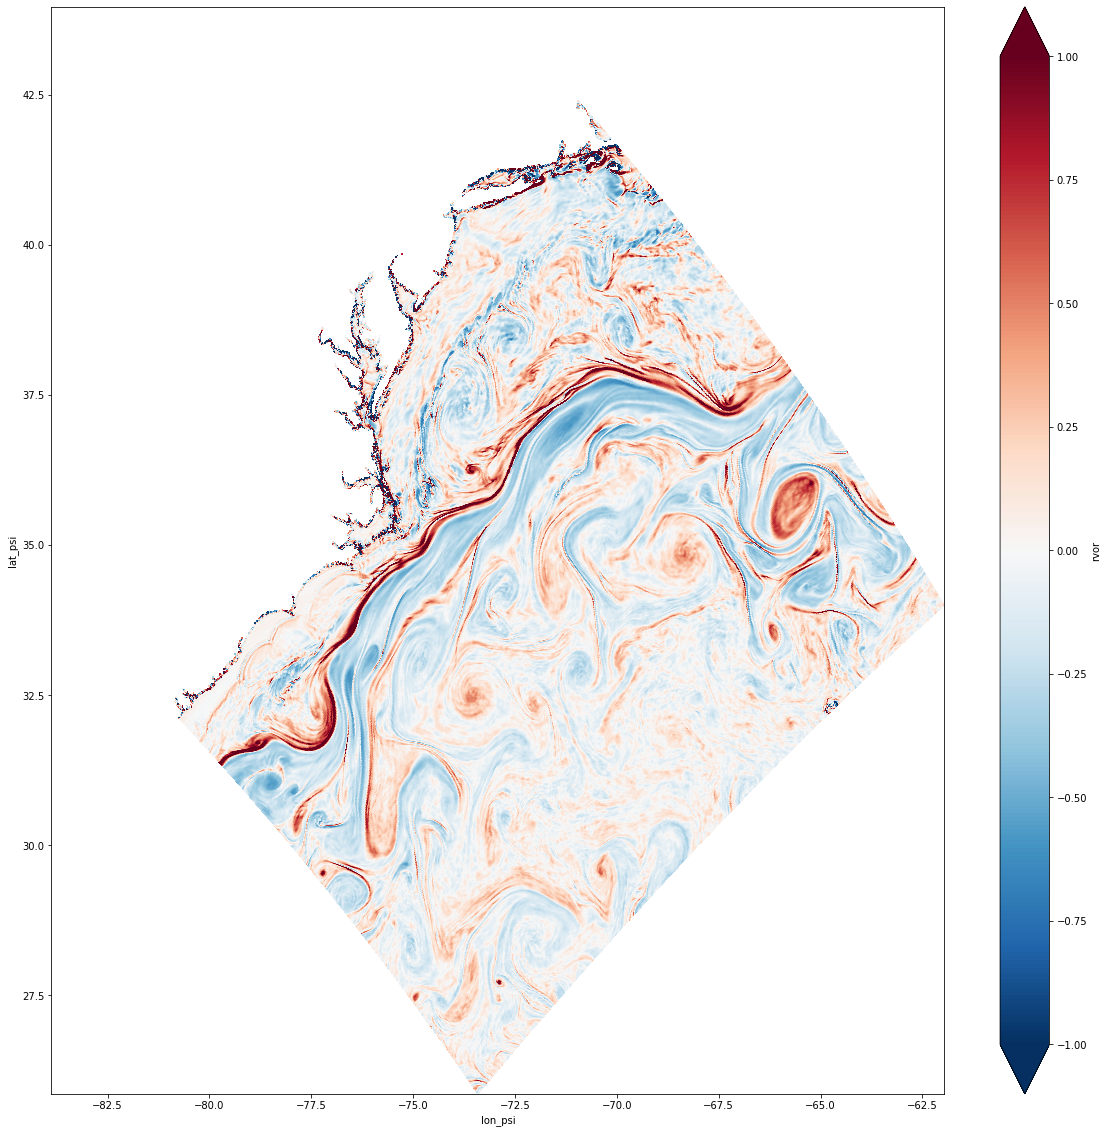

In [6]:
%%time

        
fig = plt.figure(figsize=(20,20))

%memit ds.rvor.isel(time=0).plot(x='lon_psi', y='lat_psi',\
                           vmin=-1., vmax=1., cmap='RdBu_r')

#####
